In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

## Carga de datos
Primero vamos a cargar el dataset

In [2]:
df = pd.read_csv('00_cleaned_airbnb.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13199 entries, 0 to 13198
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         13199 non-null  int64  
 1   ID                            13199 non-null  int64  
 2   Zipcode                       13199 non-null  int64  
 3   Latitude                      13199 non-null  float64
 4   Longitude                     13199 non-null  float64
 5   Accommodates                  13199 non-null  int64  
 6   Bathrooms                     13199 non-null  float64
 7   Bedrooms                      13199 non-null  int64  
 8   Beds                          13199 non-null  int64  
 9   Price                         13199 non-null  int64  
 10  Security Deposit              13199 non-null  int64  
 11  Cleaning Fee                  13199 non-null  int64  
 12  Guests Included               13199 non-null  int64  
 13  E

## Análisis univariable: Price

Como posteriormente vamos a intentar hacer un modelo que prediga el precio, este va a ser nuestro KPI principal.


In [3]:
df['Price'].describe()

count    13199.000000
mean        65.707099
std         55.706100
min          9.000000
25%         30.000000
50%         52.000000
75%         80.000000
max        875.000000
Name: Price, dtype: float64

Vemos que tenemos 13199 registros, y que los precios fluctuan entre 9 y 875 euros, una fluctuacion muy grande.
Nuestra pregunta principal es ver que caracteristicas van a tener mayor impacto en el precio.

Vamos a hacer un histograma para ver mejor la distribucion de los precios

Skewness: 4.09434404316549
Kurtosis: 30.596319204399325


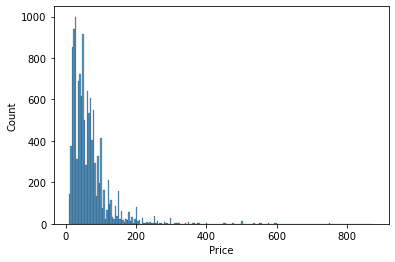

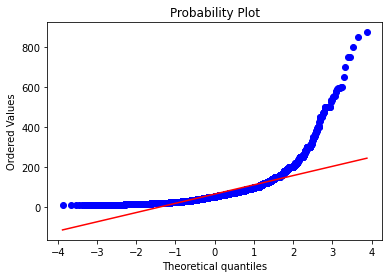

In [4]:
sns.histplot(df['Price'])
print(f"Skewness: {df['Price'].skew()}")
print(f"Kurtosis: {df['Price'].kurt()}")
plt.figure()
stats.probplot(df['Price'], plot = plt)
plt.show()

Como podemos apreciar los precios presentan un sesgo positivo y una kurtosis excesiva, no siguen una distribucion normal.

Previamente durante la limpieza de datos hemos creado una nueva columna con los precios en escala logaritmica. Volvemos a realizar el histograma con esta columna  y vemos que en escala logaritmica los precios si siguen una distribucion normal.

Skewness: 0.2145972176930533
Kurtosis: 0.0673659771160322


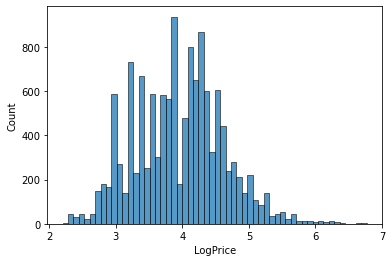

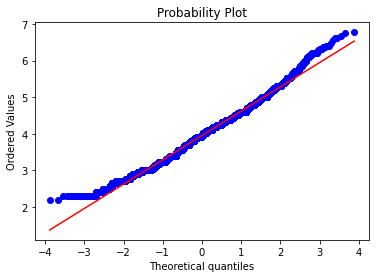

In [5]:
sns.histplot(df['LogPrice'])
print(f"Skewness: {df['LogPrice'].skew()}")
print(f"Kurtosis: {df['LogPrice'].kurt()}")
plt.figure()
res = stats.probplot(df['LogPrice'], plot = plt)

## Detección de Outliers

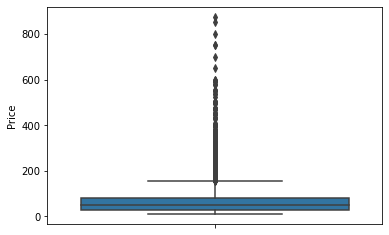

In [6]:
#Bloxplot solo del precio para ver outliers
sns.boxplot(y=df["Price"])
plt.show()

Detectamos los outliers para la variable precio. Vemos que el número de outliers es muy elevado.
Además no permiten analizar los datos correctamente.

### Eliminación de Outliers

In [7]:
# Encontramos el Q1, Q3, y el rango intercuartílico para cada columna
Q1 = df['Price'].quantile(q=.25)
Q3 = df['Price'].quantile(q=.75)
IQR = Q3 - Q1

# Solo mantenemos filas que esten dentro de 1.5*IQR de Q1 y Q3
data_clean = df[(df['Price'] >= Q1 - 1.5*IQR) & (df['Price'] <= Q3 + 1.5*IQR)]

# Calculamos cuantas filas desaparecen
data_clean.shape

(12568, 41)

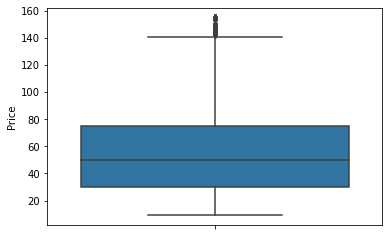

In [8]:
#Comprobamos el boxplot tras la eliminación de los outliers
sns.boxplot(y=data_clean['Price'])
plt.show()

Sigue habiendo outliers, pero el número se reduce de forma signicativa. 

## Analisis multivariable

Vamos a realizar una matriz de correlación

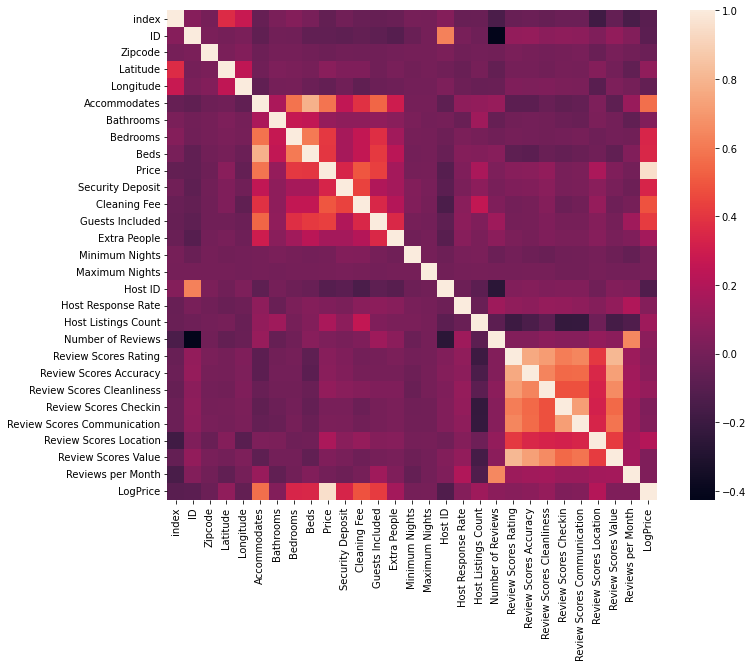

In [9]:
numeric_df = data_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(12,9))
sns.heatmap(numeric_df.corr(), square=True)
plt.show()

En esta figura los colores mas claros representan una mayor correlacion.

¿Que variables presentan una mayor correlacion con el precio?

Vemos que *Accomodates*, *Cleaning Fee* and *Bedrooms* son las que parecen tener mayor correlación.

Vamos a analizar estas variables

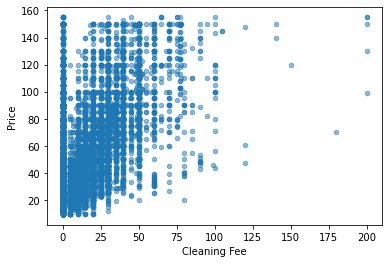

In [10]:
# Diagrama de dispersión Cleaning Fee / Price:

data = pd.concat([data_clean['Price'], data_clean['Cleaning Fee']], axis=1)
data.plot.scatter(x='Cleaning Fee', y='Price', alpha = 0.5)
plt.show()

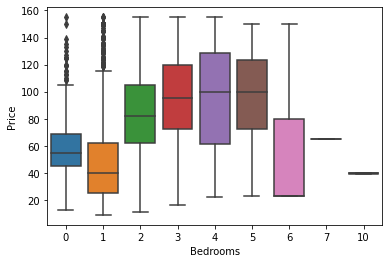

In [11]:
# Boxplots Bedrooms / Price

sns.boxplot(x='Bedrooms', y='Price', data=data_clean[['Bedrooms', 'Price']])
plt.show()

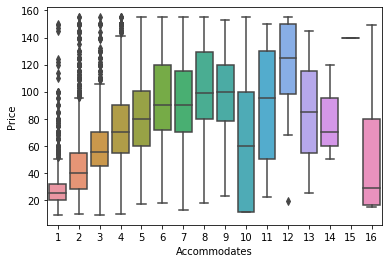

In [12]:
# Boxplots Accommodates / Price

sns.boxplot(x='Accommodates', y='Price', data=data_clean[['Accommodates', 'Price']])
plt.show()

Creamos un bloxplot para comparar los datos de Precio y Puntuaciones de los usuarios. 

En este caso vemos que no necesariamente a mayor precio, mejores valoraciones.

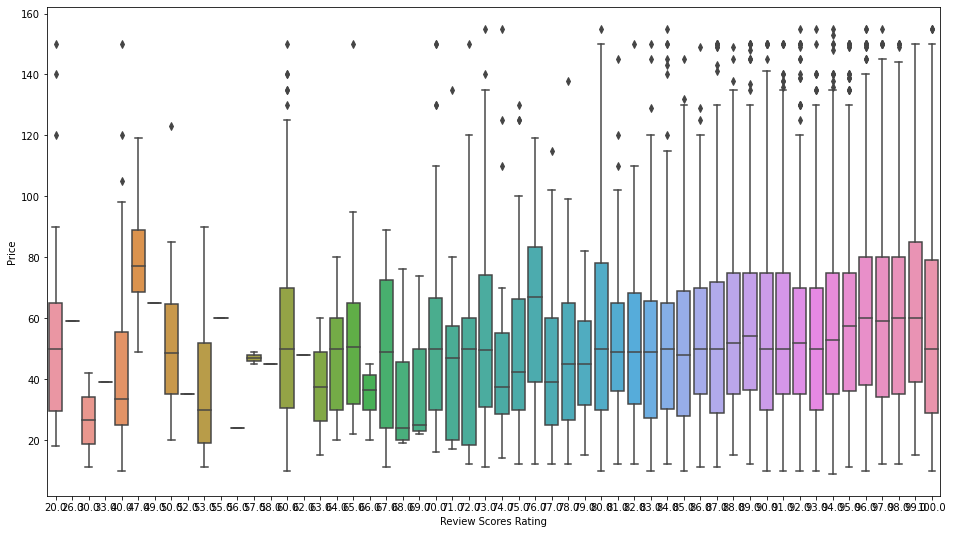

In [13]:
plt.figure(figsize=(16, 9)) 
sns.boxplot(y='Price', x='Review Scores Rating', data=data_clean[['Price', 'Review Scores Rating']])
plt.show()

Para ver de forma más clara si hay correlación entre estas dos variables hacemos un gráfico de dispersión.
En el que parece que a mayor precio, menos reviews. Aunque no parece afectar la puntuación

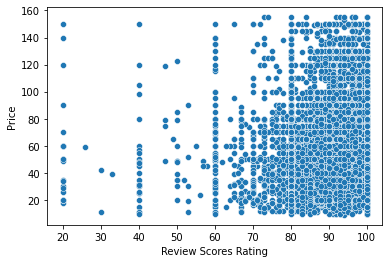

In [14]:
sns.scatterplot(x="Review Scores Rating", y="Price", data=data_clean)
plt.show()

Para determinar si el número de reviews afecta en el precio hacemos un gráfico de dispersión cruzando el precio con el número de reviews.

Vemos que los alojamientos más caros tienen un volumen menor de reviews ¿puede ser que se alquilen menos?

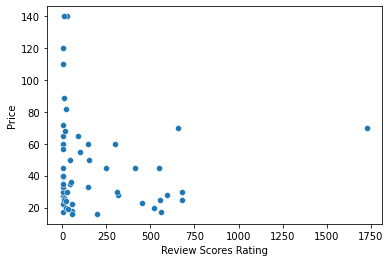

In [15]:
counts = data_clean["Review Scores Rating"].value_counts()
sns.scatterplot(y="Price", x=counts, data=data_clean)
plt.show()

### Ahora vamos a analizar la relacion con variables no numericas

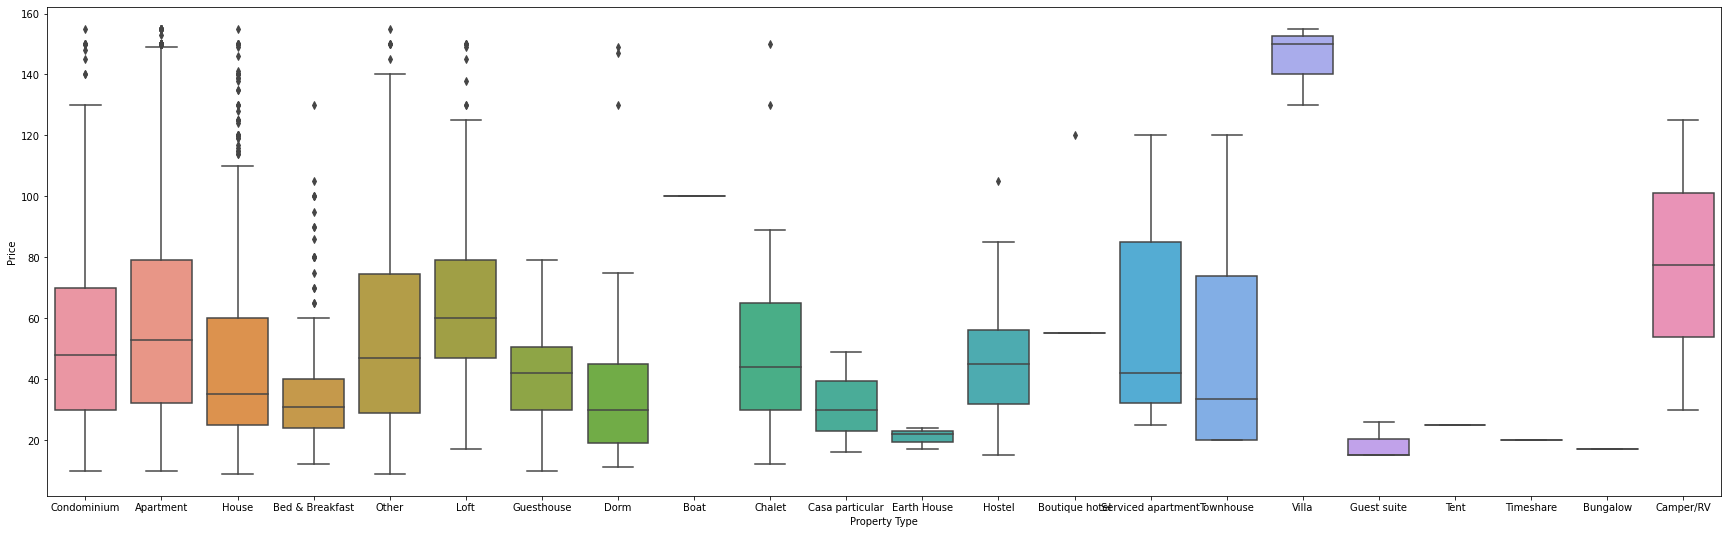

In [16]:
# Boxplot Property Type / Price

plt.figure(figsize=(30, 9))
sns.boxplot(data=data_clean, x='Property Type', y= 'Price')
plt.show()

Vemos que villa es claramente el tipo de propiedad más caro

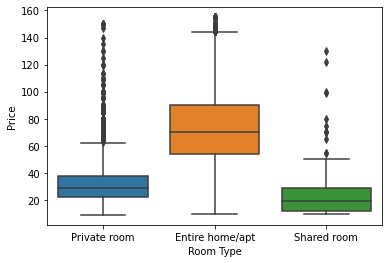

In [17]:
# Boxplot Room Type / Price

sns.boxplot(data=data_clean, x='Room Type', y= 'Price')
plt.show()

Y en cuento al tipo de Room Type más caro es Entire home/apt

In [18]:
# Precios Medios de las distintas combinaciones de Room/Proterty Type

roomProperty_price = data_clean.groupby(['Property Type','Room Type']).Price.mean()
roomProperty_price = roomProperty_price.reset_index()
roomProperty_price=roomProperty_price.sort_values('Price',ascending=[0])
roomProperty_price

,Property Type,Room Type,Price
42,Villa,Entire home/apt,145.000000
9,Camper/RV,Entire home/apt,125.000000
40,Townhouse,Entire home/apt,117.500000
12,Chalet,Entire home/apt,103.000000
6,Boat,Private room,100.000000
27,House,Entire home/apt,79.441281
33,Other,Entire home/apt,79.398058
0,Apartment,Entire home/apt,74.905917
14,Condominium,Entire home/apt,72.122807
30,Loft,Entire home/apt,67.500000


Una villa entera es la combinación más cara, mientras que una habitación compartida en una GuestHouse es la más barata.

### Ahora vamos a analizar el precio según donde esté ubicado el listing

Creamos un bloxplot por distritos, con los datos limpios algunos de ellos ya no muestran outliers (Salamanca o Retiro).
Nos permite ver qué Distritos tienen los precios más elevados:
- Centro
- Salamanca
- Chamartín
- Retiro


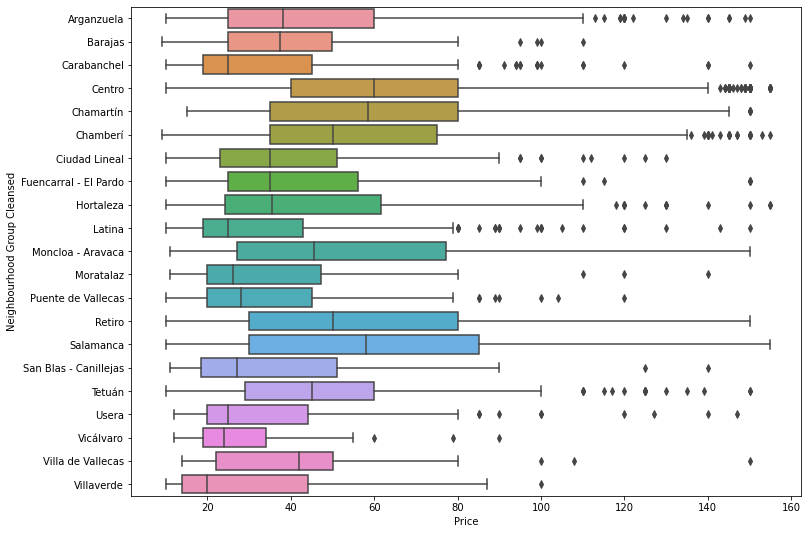

In [19]:
plt.figure(figsize=(12, 9))
sns.boxplot(y='Neighbourhood Group Cleansed', x='Price', data=data_clean[['Neighbourhood Group Cleansed', 'Price']])
# , showfliers = False
plt.show()

In [20]:
# Precios medios de los distintos tipos de Neighbourhood

N_Prices = data_clean.groupby(['Neighbourhood Cleansed']).Price.mean()
N_Prices = N_Prices.reset_index()
N_Prices=N_Prices.sort_values('Price',ascending=[0])
print(f'\nPrecios más Altos:\n\n{N_Prices.head(10)}\n')
print(f'Precios más Bajos:\n\n{N_Prices.tail(10)}')


Precios más Altos:

    Neighbourhood Cleansed      Price
98               Recoletos  81.193548
47              El Plantío  78.333333
29              Castellana  75.493151
112                    Sol  74.538550
59          Hispanoamérica  73.173913
62               Jerónimos  72.986842
39                  Cortes  70.349003
75            Nueva España  68.980769
60                   Ibiza  68.891089
56                    Goya  68.004926

Precios más Bajos:

    Neighbourhood Cleansed      Price
70              Marroquina  25.083333
84       Palomeras Sureste  24.733333
4                  Aguilas  24.437500
68             Los Rosales  24.266667
91                Portazgo  22.421053
10                  Ambroz  21.833333
42          Cuatro Vientos  21.333333
11                 Amposta  20.400000
78               Orcasitas  18.500000
101                  Rosas  17.500000


¿Tiene relacion con la renta media de cada barrio?

Para averiguarlo vamos a cargar un fichero que contiene la renta media de los hogares de los distintos barrios de Madrid (Fuente INE)

In [21]:
rentas = pd.read_csv('30677bsc.csv', sep=(';'), encoding='latin-1', decimal= ('.'))
rentas['Total'] = rentas['Total'].apply(lambda x: x.replace('.',''))
rentas['Total'] = rentas['Total'].apply(lambda x: x.replace(',','.')).astype('float').astype("Float64")
rentas = rentas.drop(['Sexo'], axis=1)
rentas = rentas.sort_values(['Total'], ascending=False)
print(f"\nRentas más Altas: \n\n{rentas['Nivel territorial: Nivel 2'].head(10)}\n")
print(f"Rentas más Bajas: \n\n{rentas['Nivel territorial: Nivel 2'].tail(10)}")


Rentas más Altas: 

24                        El Viso (Madrid)
106                       Piovera (Madrid)
18                      Recoletos (Madrid)
23                     Castellana (Madrid)
28                   Nueva España (Madrid)
55     Aravaca-Plantio-Valdemarin (Madrid)
114                       Palomas (Madrid)
50                     Mirasierra (Madrid)
17           Niño Jesús-Jerónimos (Madrid)
39                        Almagro (Madrid)
Name: Nivel territorial: Nivel 2, dtype: object

Rentas más Bajas: 

115     San Andrés-2 (Madrid)
129           Hellín (Madrid)
127           Ambroz (Madrid)
90        Numancia-1 (Madrid)
81        Pradolongo (Madrid)
82         Entrevías (Madrid)
83       San Diego-1 (Madrid)
135          Amposta (Madrid)
140      San Diego-2 (Madrid)
117    San Cristobal (Madrid)
Name: Nivel territorial: Nivel 2, dtype: object


Parece que existe relacion, entre los barrios con airbnb más caros tenemos tenemos:
- Recoletos
- Castellana
- Nueva España
- Plantío
- Jerónimos

Que también aparecen en los barrios con las rentas mas altas.

En el caso contrario tenemos por ejemplo:

- Amposta
- Ambroz